In [178]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj

NFF_PATH = '/home/wwj/Repo/playgrounds/NeuralForceField/'
ODE_PATH = '/home/wwj/Repo/projects/torchdiffeq/'

sys.path.insert(0, NFF_PATH)
sys.path.insert(0, ODE_PATH)
sys.path.insert(0, '../..')

import torch
from torch.optim import Adam
from torchdiffeq import odeint_adjoint as odeint
from torchmd.ode import ODE
from torchmd.hamiltoinians import PairPot, MLP, LennardJones, Buck, LennardJones69
from torchmd.observable import DiffRDF
from torchmd.utils import dump_mov
from nglview import show_ase, show_file, show_mdtraj

from nff.utils.scatter import compute_grad
from nff.nn.layers import GaussianSmearing
from ase import Atoms
from math import sqrt

import matplotlib
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0

matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6

matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2

matplotlib.rcParams['text.usetex'] = False

In [68]:
class NHODE(torch.nn.Module):

    def __init__(self, model, mass, target_momentum=4.0, num_chains=2, ttime = 10.0, dt= 0.005, device=0, dim=3):
        super().__init__()
        self.model = model  
        self.mass = torch.Tensor(mass).to(device)
    
        self.device = device 
        self.target_momentum = target_momentum
        self.ttime = ttime 
        self.N_dof = mass.shape[0] * dim
        self.target_ke = (0.5 * self.N_dof * self.target_momentum **2 )
        
        self.T = torch.Tensor( [self.target_momentum **2] ).to(device)
        self.num_chains = num_chains
        self.Q = np.array([1,
                   *[1]*(num_chains-1)]) 
        self.Q = torch.Tensor(self.Q).to(device)
        self.dim = dim
        
    def forward(self, t, pq):
        # pq are the canonical momentum and position variables
        with torch.set_grad_enabled(True):
            t.requires_grad = True
            pq.requires_grad = True            
            
            N = self.N_dof
            
            p = pq[:, :N]
            q = pq[:, N:2* N].reshape(-1, self.dim)
            
            sys_ke = 0.5 * (p.reshape(-1, self.dim).pow(2) / self.mass[:, None]).sum(-1) 
            
            # definite all the virtual momentums 
            p_v = pq[:, -self.num_chains:]      
            u = self.model(q, t)
            
            dHdt = torch.Tensor( [0.0] ).to(self.device) #compute_grad(inputs=t, output=u)
            dqdt = (p.reshape(-1, self.dim) / self.mass[:, None])#.reshape(-1)
            dpdt = -compute_grad(inputs=q, output=u).reshape(-1, self.dim) - p_v[:, [0]] * p / self.Q[0]
            
            dpvdt_0 = 2 * (sys_ke - self.T * self.N_dof * 0.5) - p_v[:, 0] * p_v[:, 1]/ self.Q[1]
            dpvdt_mid = (p_v[:, :-2].pow(2) / self.Q[:-2] - self.T) - p_v[:, 2:]*p_v[:, 1:-1]/ self.Q[2:]
            dpvdt_last = p_v[:, -2].pow(2) / self.Q[-2] - self.T

        f = torch.cat((dpdt, dqdt, dpvdt_0[:, None], dpvdt_mid, dpvdt_last[:, None]), dim=1)
    
        #print(f.shape)
        return f
    
class Harmonic1D(torch.nn.Module):
    def __init__(self):
        super(Harmonic1D, self).__init__()

    def forward(self, x):
        return 0.5 * x ** 2
    
class noneqharm(torch.nn.Module):
    def __init__(self, tau=100, k_0=1.0, k_tau=0.25):
        super(noneqharm, self).__init__()
        self.tau = tau
        
        self.k_0 = k_0
        self.k_tau = k_tau
        
        k_0 = torch.Tensor([k_0])
        k_tau = torch.Tensor([k_tau])
        
        self.F_0 = torch.log( k_0.sqrt() * sqrt(2 * np.pi) )
        self.F_tau = torch.log( k_tau.sqrt() * sqrt(2 * np.pi) )
        self.dF = self.F_tau - self.F_0
        
    def control(self, t): 
        return 1 - (1/self.tau) * t 
        
    def forward(self, x, t):
        return 0.5 * self.k_0 * self.control(t) * x ** 2 + 0.5 * self.k_tau * (1 - self.control(t)) * x ** 2 # spring constant changes with time 

In [69]:
# compute noequilibrium work 




In [205]:
DEVICE = 1
num_chains = 3
harm1d = noneqharm(tau=40, k_tau=0.09)

f_x = NHODE(harm1d, 
            torch.Tensor([1.0]), 
            ttime=50.0, 
            num_chains=num_chains, 
            device=DEVICE,
            target_momentum=1.0,
            dim=1).to(DEVICE)

In [206]:
harm1d.F_tau - harm1d.F_0


tensor([-1.2040])

In [209]:
dt = 0.02 
B = 16384
t_len = 2000

print(dt * 2000)

p_v = torch.empty(B, 3).normal_(mean=0,std=1)  # torch.Tensor([1.0] * num_chains)
# sample position and momentum 
q = torch.empty(B, 1).normal_(mean=0,std=1) 
p = torch.empty(B, 1).normal_(mean=0,std=1)
pq = torch.cat((p, q, p_v), dim=1).to(DEVICE)
pq.requires_grad= True

t = torch.Tensor([dt * i for i in range(t_len)]).to(DEVICE)
t.requires_grad = True

x = odeint(f_x, pq, t, method='rk4')

40.0


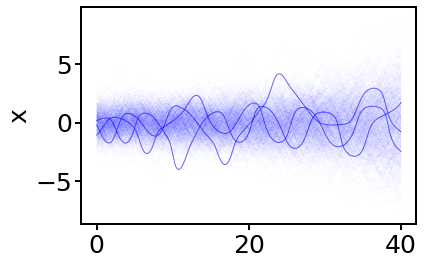

In [210]:
plt.plot( t.detach().cpu().numpy(), x[:, ::20, 1].detach().cpu().numpy(), linewidth=0.2, #color='#1f77b4',
                 c='b', alpha=0.05)

plt.plot( t.detach().cpu().numpy(), x[:, 10:13, 1].detach().cpu().numpy(), linewidth=1, color='b', alpha=0.6)

plt.ylabel("x")

plt.show()

In [211]:
W_traj = []
for i in range(B):
    qt =  x[:, i, 1].detach().reshape(-1)
    qt.requires_grad = True
    u = f_x.model(qt, t)
    dh = compute_grad(inputs=t, output=u)
    W = (dh.detach().cpu().numpy() * dt).sum()
    
    W_traj.append(W)

/home/wwj/anaconda3/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/wwj/anaconda3/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


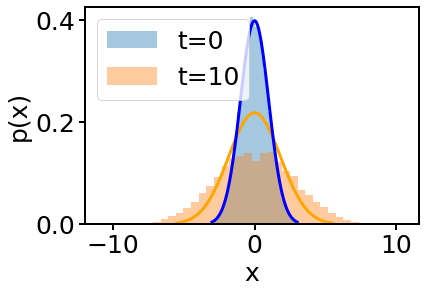

In [224]:
import math
import scipy.stats as stats

plt.hist(x[0, :, 1].detach().cpu().numpy(),bins=40, alpha=0.4, normed=True, label='t=0')
plt.hist(x[-1, :, 1].detach().cpu().numpy(),bins=40, alpha=0.4, normed=True, label='t=10')

plt.legend()
plt.xlabel("x")
plt.ylabel("p(x)")


mu = 0
variance = sqrt(1/0.09)
sigma = math.sqrt(variance)
var = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(var, stats.norm.pdf(var, mu, sigma), label='theory', color='orange')

mu = 0
variance = sqrt(1)
sigma = math.sqrt(variance)
var = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(var, stats.norm.pdf(var, mu, sigma), label='theory', color='b')

plt.show()

In [213]:
from sklearn.utils import shuffle

In [214]:
# convergence of Free Energy 

def compute_F(w):
    return -torch.log( torch.exp(-torch.Tensor(w)).mean() )


dF_mean = []
dF_std = []

sample_size = [5, 10, 20, 50, 100, 200,  500, 1000, 2500, 5000, 10000]

for batch in sample_size:
    
    dF_stat = []
    
    for sample in range(5):
        W_traj = shuffle(W_traj)
        dF = compute_F(W_traj[:batch])
        dF_stat.append(dF)
    
    std = np.array(dF_stat).std()
    mean = np.array(dF_stat).mean()
    
    dF_mean.append(mean)
    dF_std.append(std)

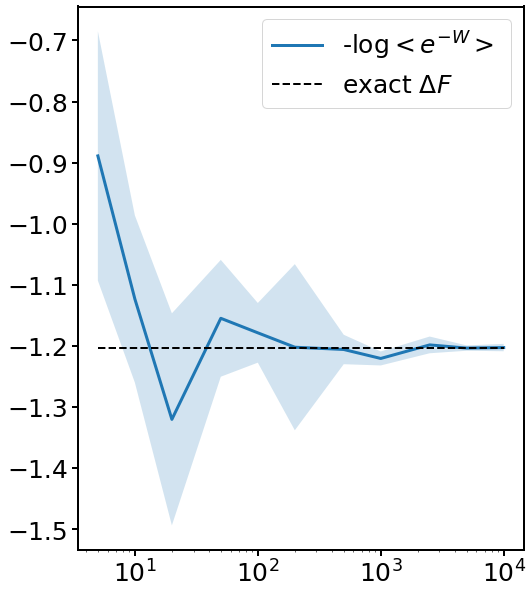

In [215]:
dF_mean = np.array(dF_mean)
dF_std = np.array(dF_std)
 
plt.figure(figsize=(8,10))
plt.plot(sample_size, dF_mean, label='-$\log < e^{-W} > $ ')
plt.fill_between(sample_size, dF_mean - dF_std, dF_mean + dF_std, interpolate=True, alpha=0.2)
plt.xscale("log")
plt.plot(sample_size, [f_x.model.dF ] * len(sample_size), linestyle='--', linewidth=2, c='black', 
        label='exact $\Delta F$')
plt.legend()
plt.show()

In [225]:
# construct basis set for control protocols 

In [261]:
def basis(x, n = 2):
    return np.cos( (np.pi /2 + n * 2 * np.pi) *x)

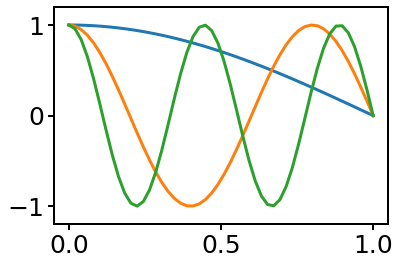

In [266]:
x = np.linspace(0, 1)

plt.plot(x, basis(x, n=0))
plt.plot(x, basis(x, n=1))
plt.plot(x, basis(x, n=2))
plt.ylim(-1.2, 1.2)
plt.show()

In [267]:
x = torch.linspace(0, 1, 100).reshape()

In [268]:
n = torch.Tensor([0, 1, 2, 3])

In [283]:
control = torch.cos((np.pi /2 + n * 2 * np.pi) * x[:, None]) 

coeffs = torch.Tensor([1.0, 0.1, 0.1, 0.1])

coeffs = coeffs.abs()/ coeffs.abs().sum()

In [287]:
protocol = (control * coeffs.reshape(-1, 4)).sum(1)

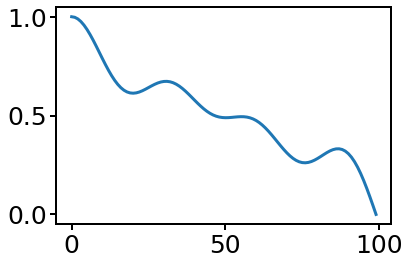

In [289]:
plt.plot( protocol.cpu())